In [2]:
#Import Libraries
from typing import Optional, Any
import warnings
from tifffile import TiffFile, TiffWriter
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow as tf

In [3]:
def read_stiff(filename: str, silent=False, rgb_only=False):
    """

    :param filename:    filename of the spectral tiff to read.
    :return:            Tuple[spim, wavelengths, rgb, metadata], where
                        spim: spectral image cube of form [height, width, bands],
                        wavelengths: the center wavelengths of the bands,
                        rgb: a color render of the spectral image [height, width, channels] or None
                        metadata: a free-form metadata string stored in the image, or an empty string
    """
    TIFFTAG_WAVELENGTHS = 65000
    TIFFTAG_METADATA = 65111
    spim = None
    wavelengths = None
    rgb = None
    metadata = None

    first_band_page = 0
    with TiffFile(filename) as tiff:
        # The RGB image is optional, the first band image maybe on the first page:
        first_band_page = 0
        if tiff.pages[first_band_page].ndim == 3:
            rgb = tiff.pages[0].asarray()
            # Ok, the first band image is on the second page
            first_band_page = first_band_page + 1

        multiple_wavelength_lists = False
        multiple_metadata_fields = False
        for band_page in range(first_band_page, len(tiff.pages)):
            # The wavelength list is supposed to be on the first band image.
            # The older write_tiff writes it on all pages, though, so make
            # a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_WAVELENGTHS)
            tag_value = tag.value if tag else tuple()
            if tag_value:
                if wavelengths is None:
                    wavelengths = tag_value
                elif wavelengths == tag_value:
                    multiple_wavelength_lists = True
                elif wavelengths != tag_value:
                    # Well, the image is just broken then?
                    raise RuntimeError(f'Spectral-Tiff "{filename}" contains multiple differing wavelength lists!')

            # The metadata string, like the wavelength list, is supposed to be
            # on the first band image. The older write_tiff wrote it on all
            # pages, too. Make a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_METADATA)
    
            tag_value = tag.value if tag else ''
            if tag_value:
                if metadata is None:
                    metadata = tag_value
                elif metadata == tag_value:
                    multiple_metadata_fields = True
                elif metadata != tag_value:
                    # Well, for some reason there are multiple metadata fields
                    # with varying content. This version of the function does
                    # not care for such fancyness.
                    raise RuntimeError(f'Spectral-Tiff "{filename}" contains multiple differing metadata fields!')

        # The metadata is stored in an ASCII string. It may contain back-slashed
        # hex sequences (unicode codepoints presented as ASCII text). Convert
        # ASCII string back to bytes and decode as unicode sequence.
        if metadata:
            metadata = metadata.encode('ascii').decode('unicode-escape')
        else:
            metadata = ''

        # Some of the early images may have errorneus metadata string.
        # Attempt to fix it:
        if len(metadata) >= 2 and metadata[0] == "'" and metadata[-1] == "'":
            while metadata[0] == "'":
                metadata = metadata[1:]
            while metadata[-1] == "'":
                metadata = metadata[:-1]
            if '\\n' in metadata:
                metadata = metadata.replace('\\n', '\n')

        # Generate a fake wavelength list, if the spectral tiff has managed to
        # lose its own wavelength list.
        if not wavelengths:
            wavelengths = range(0, len(tiff.pages) - 1 if rgb is not None else len(tiff.pages))

        if multiple_wavelength_lists and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated wavelength lists!')
        if multiple_metadata_fields and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated metadata fields!')

        if not rgb_only:
            spim = tiff.asarray(key=range(first_band_page, len(tiff.pages)))
            spim = np.transpose(spim, (1, 2, 0))
        else:
            spim = None

        # Make sure the wavelengths are in an ascending order:
        if wavelengths[0] > wavelengths[-1]:
            spim = spim[:, :, ::-1] if spim is not None else None
            wavelengths = wavelengths[::-1]

    # Convert uint16 cube back to float32 cube
    if spim is not None and spim.dtype == 'uint16':
        spim = spim.astype('float32') / (2**16 - 1)

    return spim, np.array(wavelengths), rgb, metadata

In [4]:
def read_mtiff(filename):
    """
    Read a mask bitmap tiff.

    Mask bitmap tiff contains multiple pages of bitmap masks. The mask label
    is stored in tag 65001 in each page. The mask label is stored as an ASCII
    string that may contain unicode codepoints encoded as ASCII character
    sequences (see unicode-escape encoding in Python docs).

    :param filename:    filename of the mask tiff to read.
    :return:            Dict[label: str, mask: ndarray], where
                        label: the mask label
                        mask: the boolean bitmap associated with the label.
    """
    TIFFTAG_MASK_LABEL = 65001
    masks = dict()
    with TiffFile(filename) as tiff:
        for p in range(0, len(tiff.pages)):
            label_tag = tiff.pages[p].tags.get(TIFFTAG_MASK_LABEL)
            if label_tag is None:
                if p > 0:
                    print(f'** page {p}: no TIFF_MASK_LABEL tag. Ignored.')
                continue
            label = label_tag.value.encode('ascii').decode('unicode-escape')
            mask = tiff.asarray(key=p)
            masks[label] = mask > 0
    return masks

In [5]:
def getLabelCode(label_name, classes):
  if not label_name in classes:
      classes.append(label_name) 
  return classes.index(label_name)

In [6]:
def getUnetModel(n_classes):
  inputs = tf.keras.layers.Input((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))
  #Downsampling Layers
  c1 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(inputs)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c1)
  p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

  c2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c2)
  p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

  c3 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p2)
  c3 = tf.keras.layers.Dropout(0.1)(c3)
  c3 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c3)
  p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

  c4 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4)

  c5 = tf.keras.layers.Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c5)

  #Expansive path/Upsampling Layers
  u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c5)
  u6 = tf.keras.layers.concatenate([u6,c4])
  c6 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c6)

  u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c6)
  u7 = tf.keras.layers.concatenate([u7,c3])
  c7 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c7)

  u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c7)
  u8 = tf.keras.layers.concatenate([u8,c2])
  c8 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c8)

  u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding="same")(c8)
  u9 = tf.keras.layers.concatenate([u9,c1])
  c9 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c9)

  outputs  = tf.keras.layers.Conv2D(n_classes, (1,1), activation="softmax")(c9)
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  return model

In [8]:
from google.colab import drive
drive.mount('/content/idp')

Drive already mounted at /content/idp; to attempt to forcibly remount, call drive.mount("/content/idp", force_remount=True).


In [9]:
from os import listdir
IMAGE_SIZE=128
IMAGE_CHANNELS = 38
root_path = 'idp/My Drive/IndustrialProject2021/'
REFLECTANCE_IMAGE_PATH = root_path+"datasets/"
MASK_IMAGE_PATH = root_path+"masks/"
combined_spectra = []
combined_labels = []
all_labels = []
classes = ["background"]
X = []
y=[]
image_filenames = listdir(REFLECTANCE_IMAGE_PATH)
for filename in image_filenames:
    spectra_image, wavelength, rgb, metadata = read_stiff(f"{REFLECTANCE_IMAGE_PATH}/{filename}")
    image_name = filename.split(".tif")[0]
    mask_image_name = f"{image_name}_masks.tif"
    image_masks_dict = read_mtiff(f"{MASK_IMAGE_PATH}/{mask_image_name}")
    features = []
    masks  = np.zeros((spectra_image.shape[:2]))
    for label in image_masks_dict:
      spectra_image_mask = image_masks_dict[label].astype(int)
      label_code = getLabelCode(label,classes)
      spectra_image_mask[spectra_image_mask == 1] = label_code
      masks = np.maximum(masks,spectra_image_mask)
    y.append(resize(masks,(IMAGE_SIZE,IMAGE_SIZE)))
    X.append(resize(spectra_image,(IMAGE_SIZE,IMAGE_SIZE)))

(array([169279.,  18361.,  44695.,  48420.,  84379., 127781.,  69224.,
        109043.,   5645.,  27685.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

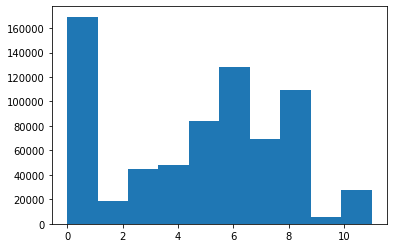

In [10]:
y = np.array(y).astype(int)
X = np.array(X)
plt.hist(y.flatten())

In [11]:
annotation_file_name = "annotation.npy"
class_colors = np.array([[0,0,0],[255,0,0],[255,255,0],[0,234,255],[170,0,255],[255,127,0],[0,149,255],
                  [255,0,170],[106,255,0],[0,64,255],[35,98,143],[143,106,35]])
reshaped_classes = np.array(classes).reshape(-1,1)
anotations = np.concatenate((reshaped_classes,class_colors),axis=1)
np.save(annotation_file_name,anotations)

In [13]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
n, h, w = y.shape
y_reshaped = y.reshape(-1)
y_reshaped_encoded = labelEncoder.fit_transform(y_reshaped)
print(np.unique(y_reshaped))
y_encoded = y_reshaped_encoded.reshape(n,h,w)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [107]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
y_expanded = np.expand_dims(y,axis=3)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)
y_train_cat = to_categorical(y_train)

In [108]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight("balanced",np.unique(y_reshaped),y_reshaped)
class_weights = {l:c for l,c in zip(np.unique(y_reshaped), class_weights)}
sample_weights = class_weight.compute_sample_weight(class_weights,y_train.reshape(-1,1))
y_n, y_h, y_w = y_train.shape
sample_weights = sample_weights.reshape(y_n,y_h,y_w)

In [18]:
model = getUnetModel(len(classes))
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"],sample_weight_mode="temporal")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 38 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 5488        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
#Train and Save the trained Model
model_filename="multiclass_semanctic_x200.hdf5"
history = model.fit(X_train,y_train_cat,batch_size=2,epochs=500,sample_weight=sample_weights)
model.save(model_filename)

In [ ]:
#Plot the Lost during the Training
loss  = history.history["loss"]
plt.plot(loss, "y",label="Training Loss")
plt.ylabel("Model Loss")
plt.legend()
plt.show()

0.7942165798611112
['background', 'ICG', 'Blue dye', 'Specular reflection', 'Artery', 'Vein', 'Stroma', 'Artery, ICG', 'Stroma, ICG', 'Suture', 'Umbilical cord']


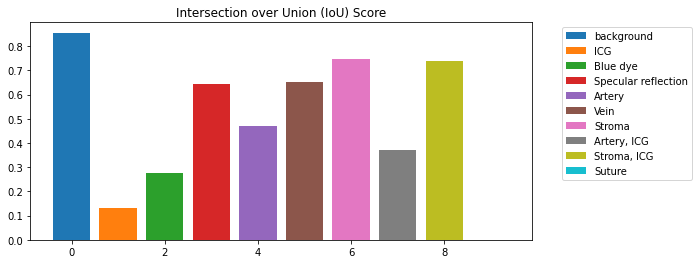

In [109]:
from sklearn.metrics import accuracy_score, confusion_matrix, jaccard_score
y_preds = model.predict(X_test)
y_preds = np.argmax(y_preds,axis=3)
flattened_y_preds = y_preds.flatten()
flattended_y_test = y_test.flatten()
cm = confusion_matrix(flattened_y_preds,flattended_y_test)
iou = jaccard_score(flattened_y_preds,flattended_y_test,average=None)
print(accuracy_score(flattened_y_preds,flattended_y_test))
class_colors_dict = dict(enumerate(class_colors))
classed_dict = dict(enumerate(classes))
print(classes[:11])
plt.rcParams["figure.figsize"] = (9,4)
for index, iou_value in enumerate(iou):
  plt.bar(index,iou_value)
plt.title("Intersection over Union (IoU) Score")
plt.legend(classes,bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

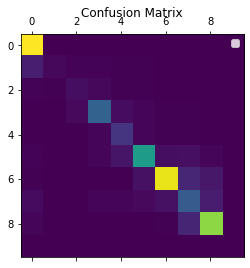

['background', 'ICG', 'Blue dye', 'Specular reflection', 'Artery', 'Vein', 'Stroma', 'Artery, ICG', 'Stroma, ICG', 'Suture', 'Umbilical cord', 'Red dye']


In [110]:
plt.rcParams["figure.figsize"] = (9,4)
plt.matshow(cm)
plt.title("Confusion Matrix")
plt.legend(classes)
plt.show()
print(classes)

In [ ]:
from sklearn.metrics import accuracy_score
model_filename="multiclass_semanctic_x200.hdf5"
model.load_weights(root_path+model_filename)
y_predictions = model.predict(X_test)
predictions = np.argmax(y_predictions,axis=3)
print(np.unique(predictions[0]))
print(np.unique(y_test[0]))
score = accuracy_score(predictions[1].flatten(),y_test[1].flatten())
print(score)

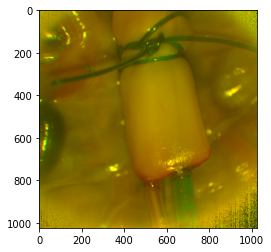

In [73]:
filename = "lower_10_icg.tif"
spim, wavelength, rgb_img, metadata = read_stiff(f"{REFLECTANCE_IMAGE_PATH}/{filename}")
plt.imshow(rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


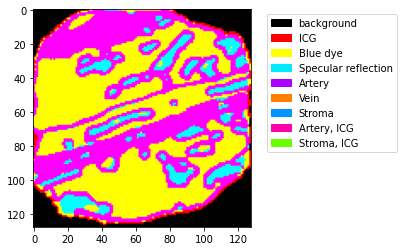

In [103]:
resized_image = resize(spim,(IMAGE_SIZE,IMAGE_SIZE))
test_image = np.array([resized_image])
test_predictions = model.predict(test_image)
test_predictions = np.argmax(test_predictions,axis=3)
unique_prediction_classes = np.unique(test_predictions)
segmented_image = np.zeros((IMAGE_SIZE,IMAGE_SIZE,3))
test_predictions_rgb = np.stack((test_predictions,)*3, axis=-1)
predicted_class = dict()
for prediction in unique_prediction_classes:
  predicted_class[prediction] = classes[prediction]
  if prediction != 0:
    predicted_color = class_colors[prediction]
    predicted_color_rgb = [prediction,prediction,prediction];
    t = np.where(test_predictions_rgb==predicted_color_rgb,predicted_color,[0,0,0])
    segmented_image = np.maximum(segmented_image,t)
plt.imshow(segmented_image[0])
from matplotlib.patches import Rectangle
handles = [
    Rectangle((0,0),1,1, color = (class_colors[index]/255)) for index in range(len(classes))
]
plt.legend(handles,predicted_class.values(),bbox_to_anchor=(1.05, 1),loc='upper left')
plt.savefig("test.jpg")